# Titanic Survivor Prediction Project

<br>

This notebook presents a machine learning project on the classic Titanic dataset. Briefly speaking, the goal is to develop a model that predicts whether a passenger would survive given a set of information. Here, this notebook documents the entire trajectory of the project, which primarily consists of the following sections:

1. [Data Exploration](#1)


2. [Feature Engineering](#2)


3. [Modeling](#3)


4. [Validation](#4)


5. [Prediction on Test Set](#5)

You may visit the <a href='https://www.kaggle.com/c/titanic'>Kaggle competition page</a> for more detailed information about the dataset.

<br>

<img src='img/titanic.jpg' title='Titanic' width=600 height=400>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='whitegrid')
import re
import joblib

np.random.seed(1995)

<a id=1></a>

# Data Exploration

## A. Load in Training Data

In [2]:
# Load data
trainData = pd.read_csv('data/train.csv')

In [3]:
trainData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## B. Univariate Analysis

**i) Target variable: Survived**

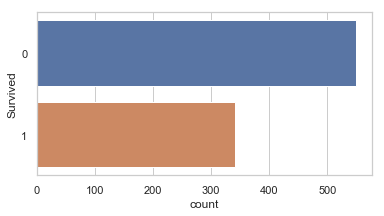

In [4]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.countplot(y='Survived', data=trainData, ax=ax)

**ii) Pclass**

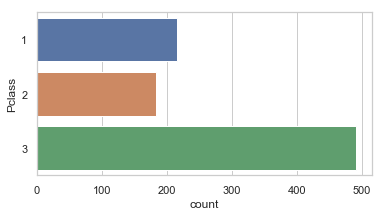

In [5]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.countplot(y='Pclass', data=trainData, ax=ax)

**iii) Sex**

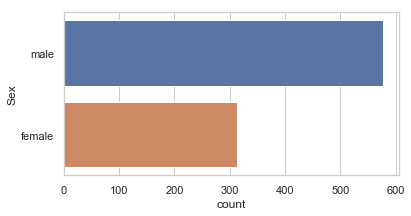

In [6]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.countplot(y='Sex', data=trainData, ax=ax)

**iv) Age**

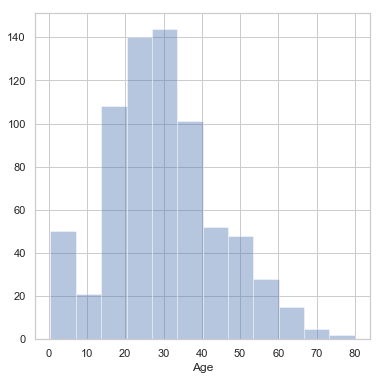

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot(trainData.Age.dropna(), kde=False, bins=12, ax=ax)

**v) Fare**

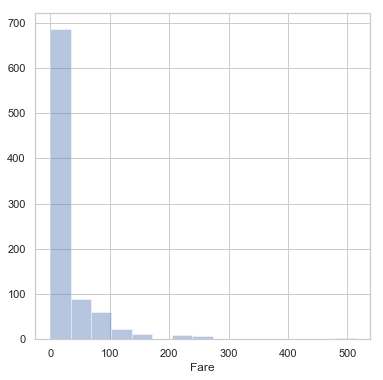

In [10]:
fig, ax = plt.subplots(figsize=(6, 6))
sns.distplot(trainData.Fare, kde=False, bins=15, ax=ax)

In [12]:
trainData.Fare.sort_values(ascending=False)

679    512.3292
258    512.3292
737    512.3292
341    263.0000
438    263.0000
         ...   
277      0.0000
633      0.0000
302      0.0000
597      0.0000
271      0.0000
Name: Fare, Length: 891, dtype: float64

**vi) Embarked**

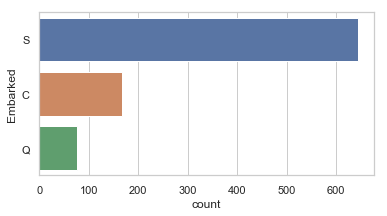

In [13]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.countplot(y='Embarked', data=trainData, ax=ax)

## C. Exploration and Cleaning

First we will examine which columns contain missing values.

In [4]:
trainData.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Age

It turns out that whether **Age** is missing makes a perceptible difference in the chance of survival.

In [5]:
tempDF = trainData[['Survived', 'Age']]
tempDF['AgeExists'] = pd.notna(tempDF.Age)

tempDF[['Survived', 'AgeExists']].groupby('AgeExists').mean().sort_values('Survived', ascending=False)

/Users/zexi_ye/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Survived
AgeExists,
True,0.406162
False,0.293785


### Cabin

Likewise, whether **Cabin** is missing leads to a substantial discrepancy in the chance of survival.

In [6]:
tempDF = trainData[['Survived', 'Cabin']]
tempDF['CabinExists'] = pd.notna(tempDF.Cabin)

tempDF[['Survived', 'CabinExists']].groupby('CabinExists').mean().sort_values('Survived', ascending=False)

/Users/zexi_ye/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Survived
CabinExists,
True,0.666667
False,0.299854


### Embarked

For the column **Embarked**, since there are only 2 missing records, we will impute this field with the most common category.

In [7]:
embarkedMode = trainData.Embarked.mode().iloc[0]

trainData['Embarked'] = trainData.Embarked.fillna(embarkedMode)

### Ticket

We are curious about whether Ticket contains characters would have an impact on the passenger's chance of survival, yet the data exhibit that it does not make a difference.

In [8]:
tempDF = trainData[['Ticket', 'Survived']]
tempDF['TicketChar'] = tempDF.Ticket.apply(lambda x: int(x.lower().islower()))

tempDF[['Survived', 'TicketChar']].groupby('TicketChar').mean().sort_values('Survived', ascending=False)

/Users/zexi_ye/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Survived
TicketChar,
0,0.384266
1,0.382609


<a id=2></a>

# Feature Engineering

In this section, we will create a number of features based upon existing columns. Here is a list of features that will be engineered.

<br>

1. <font color='green'>NumFamMember</font> (int) - We add up SibSp and Parch to compute the number of family members who are on board with the passenger.


2. <font color='green'>IsAlone</font> (binary) - From NumFamMember, we create a binary variable that indicates whether the passenger is on board alone. 0 means the passenger is traveling alone and 1 means he/she travels with at least one family member. 


3. <font color='green'>Title</font> (str) - We parse the title from passenger's name and denote it by "Title." For instance, "Mr." For titles other than common titles "Mr.", "Miss.", "Mrs." and "Master.", we will address them by combining them into the most similar categories in the common titles or grouping them into a separate category called "Rare."  


4. <font color='green'>AgeExists</font> (binary) - Whether Age exists. 0 means missing and 1 means it exists.


5. <font color='green'>AgeGroup</font> (int) - Age will be grouped into age ranges in an ordinal manner.


6. <font color='green'>CabinExists</font> (binary) - Whether Cabin exists. 0 means missing and 1 means it exists.


7. <font color='green'>Pclass * Sex</font> (int) - An interaction term between Pclass and Sex. Since Pclass and Sex account for large variation in the chance of survival, we speculate that an interaction term would come handy.


8. <font color='green'>FareGroup</font> (int) - Fare will be grouped in fare ranges in an ordinal manner.


9. <font color='green'>FarePerPersonGroup</font> (int) - Fare paid per person among family, grouped in an ordinal manner.

In [9]:
trainData.Name.str.extract(' ([A-Za-z]+)\.', expand=False).value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Mlle          2
Major         2
Col           2
Sir           1
Mme           1
Lady          1
Jonkheer      1
Capt          1
Ms            1
Countess      1
Don           1
Name: Name, dtype: int64

In [2]:
from collections import defaultdict

# Create a dict that maps raw title to the desired end title
titleCorrectionDict = defaultdict(lambda: 'Rare')
titleCorrectionDict['Mr'] = 'Mr'
titleCorrectionDict['Miss'] = 'Miss'
titleCorrectionDict['Mrs'] = 'Mrs'
titleCorrectionDict['Master'] = 'Master'
titleCorrectionDict['Mlle'] = 'Miss'
titleCorrectionDict['Mme'] = 'Mrs'
titleCorrectionDict['Ms'] = 'Miss'

# Create a dict that maps end title to a numerical identifier
titleToNum = {'Mr': 0, 'Miss': 1, 'Mrs': 2, 'Master': 3, 'Rare': 4}

In [3]:
def getBucket(value, intervals):
    for i, upperBound in enumerate(intervals):
        if value <= upperBound:
            return i
        
    return len(intervals)
    

In [4]:
def augmentDataFrame(df, titleCorrectionDict, titleToNum, ageRange, fareRange, farePerPersonRange):
    # Make a deep copy
    df = df.copy()
    
    # Perform index encoding on categorical variables
    df['Sex'] = df.Sex.map({'male': 0, 'female': 1})
    df['Embarked'] = df.Embarked.map({'S': 0, 'Q': 1, 'C': 2})
    
    # 1. NumFamMember
    df['NumFamMember'] = df.SibSp + df.Parch
    
    # 2. IsAlone
    df['IsAlone'] = (df.NumFamMember == 0).astype(int)
    
    # 3. Title
    # Isolate the title part from Name
    df['Title'] = df.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # Convert the raw title into the desired title
    df['Title'] = df.Title.map(titleCorrectionDict)
    # Index encoding
    df['Title'] = df.Title.map(titleToNum)
    
    # 4. AgeExists
    df['AgeExists'] = pd.notna(df.Age).astype(int)
    
    # 5. AgeGroup
    # Fill na in age with median
    df['Age'] = df.Age.fillna(df.Age.median())
    df['AgeGroup'] = df.Age.apply(lambda x: getBucket(x, ageRange))

    # 6. CabinExists
    df['CabinExists'] = pd.notna(df.Cabin).astype(int)
    
    # 7. Pclass * Sex
    df['Pclass_Sex'] = df.Pclass * df.Sex
    
    # 8. FareGroup
    df['FareGroup'] = df.Fare.apply(lambda x: getBucket(x, fareRange))    
    
    # 9. FarePerPerson
    df['FarePerPerson'] = df.Fare / (df.NumFamMember + 1)
    df['FarePerPersonGroup'] = df.FarePerPerson.apply(lambda x: getBucket(x, farePerPersonRange))
    
    return df

In [5]:
def cleanAndOneHotEncoding(df, keepCols, encodeCols):
    df = df.copy()[keepCols]
    df = pd.get_dummies(df, columns=encodeCols, drop_first=True)
    return df

**Augment the training data frame**

In [6]:
# Define grouping thresholds
ageRange = [16, 32, 48, 64]
fareRange = [7.854, 10.5, 21.679, 39.688]
farePerPersonRange = [7.142, 7.896, 10.5, 26.55]

In [15]:
# Transform!
trainDataAugmented = augmentDataFrame(trainData, titleCorrectionDict, titleToNum, ageRange, fareRange, farePerPersonRange)

In [16]:
trainDataAugmented.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'NumFamMember',
       'IsAlone', 'Title', 'AgeExists', 'AgeGroup', 'CabinExists',
       'Pclass_Sex', 'FareGroup', 'FarePerPerson', 'FarePerPersonGroup'],
      dtype='object')

In [17]:
# Drop extraneous columns and conduct one-hot encoding
keepCols = ['Survived',
            'Pclass',
            'Sex',
            'Embarked',
            'NumFamMember',
            'IsAlone',
            'Title',
            'AgeExists',
            'AgeGroup',
            'CabinExists',
            'Pclass_Sex',
            'FareGroup',
            'FarePerPersonGroup']
encodeCols = ['Embarked', 'Title']
trainDataCleaned = cleanAndOneHotEncoding(trainDataAugmented, keepCols, encodeCols)

In [18]:
trainDataAugmented.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'NumFamMember',
       'IsAlone', 'Title', 'AgeExists', 'AgeGroup', 'CabinExists',
       'Pclass_Sex', 'FareGroup', 'FarePerPerson', 'FarePerPersonGroup'],
      dtype='object')

In [19]:
trainDataCleaned

,Survived,Pclass,Sex,NumFamMember,IsAlone,AgeExists,AgeGroup,CabinExists,Pclass_Sex,FareGroup,FarePerPersonGroup,Embarked_1,Embarked_2,Title_1,Title_2,Title_3,Title_4
0,0,3,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,1,2,1,1,4,4,0,1,0,1,0,0
2,1,3,1,0,1,1,1,0,3,1,2,0,0,1,0,0,0
3,1,1,1,1,0,1,2,1,1,4,3,0,0,0,1,0,0
4,0,3,0,0,1,1,2,0,0,1,2,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,0,0,1,1,1,0,0,2,3,0,0,0,0,0,1
887,1,1,1,0,1,1,1,1,1,3,4,0,0,1,0,0,0
888,0,3,1,3,0,0,1,0,3,3,0,0,0,1,0,0,0
889,1,1,0,0,1,1,1,1,0,3,4,0,1,0,0,0,0


## Train-Val Split

We will split the training dataset into training set and validation set with a ratio of 90-10.

In [20]:
# Isolate X and Y
X = trainDataCleaned.drop(columns=['Survived'])
y = trainDataCleaned.Survived

In [21]:
from sklearn.model_selection import train_test_split

val_frac = 0.1

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_frac, random_state=1995)

**Here we save the training set and the validation set into two separate files.**

In [184]:
# Save training set
trainData.loc[X_train.index].to_csv('data/training_set.csv', index=False)

# Save validation set
trainData.loc[X_val.index].to_csv('data/validation_set.csv', index=False)

**A snapshot of training set's features**

In [22]:
X_train.head()

,Pclass,Sex,NumFamMember,IsAlone,AgeExists,AgeGroup,CabinExists,Pclass_Sex,FareGroup,FarePerPersonGroup,Embarked_1,Embarked_2,Title_1,Title_2,Title_3,Title_4
505,1,0,1,0,1,1,1,0,4,4,0,1,0,0,0,0
31,1,1,1,0,0,1,1,1,4,4,0,1,0,1,0,0
513,1,1,1,0,1,3,0,1,4,4,0,1,0,1,0,0
834,3,0,0,1,1,1,0,0,1,2,0,0,0,0,0,0
595,3,0,2,0,1,2,0,0,3,2,0,0,0,0,0,0


<a id=3></a>

# Modeling

The following machine learning will be used to build classifiers.

<br>

<font color='green'>

1) Logistic Regression

2) Support Vector Machine (SVM)

3) K-Nearest Neighbors (K-NN)

4) Naive Bayes

5) Random Forests

6) Gradient Boosting Trees

7) Blending
    
</font>

## 1) Logistic Regression

In [142]:
from sklearn.linear_model import LogisticRegressionCV

Cs = [10**t for t in range(-3, 5)]
l1_ratios = np.array([0.0, 0.25, 0.5, 0.75, 1.0])
clfLogistic = LogisticRegressionCV(Cs=Cs,
                                   penalty='elasticnet',
                                   cv=5,
                                   max_iter=1000,
                                   random_state=1995,
                                   solver='saga',
                                   l1_ratios=l1_ratios).fit(X_train, y_train)

In [156]:
clfLogistic.Cs_

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04])

In [154]:
clfLogistic.C_

array([1.])

In [155]:
clfLogistic.l1_ratio_

array([0.75])

In [160]:
Cs = [0.5, 0.75, 1, 2, 5]
l1_ratios = np.array([0.65, 0.7, 0.75, 0.8, 0.85, 0.9])
clfLogistic = LogisticRegressionCV(Cs=Cs,
                                   penalty='elasticnet',
                                   cv=5,
                                   max_iter=1000,
                                   random_state=1995,
                                   solver='saga',
                                   l1_ratios=l1_ratios).fit(X_train, y_train)

In [161]:
clfLogistic.C_

array([2.])

In [162]:
clfLogistic.l1_ratio_

array([0.85])

In [163]:
clfLogistic.score(X_train, y_train)

0.83270911360799

In [164]:
clfLogistic.score(X_val, y_val)

0.8555555555555555

**Save the logistic regression classifier**

In [ ]:
from sklearn.externals import joblib

# Save model
outPath = 'models/lr.pickle'
joblib.dump(clfLogistic, outPath)

## 2) Support Vector Machine (SVM)

In [23]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

**Standardize the training set**

In [24]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_val_std = scaler.transform(X_val)

**Cross-validation**

Linear kernel

In [31]:
# Param grid for SVM
param_grid = {'kernel': ['linear'], 'C': [10**t for t in range(-2, 3)]}

# Instantiate SVM classifier
svcClf_linear = SVC()

# Cross-validation
cv = GridSearchCV(svcClf_linear, param_grid=param_grid, cv=5)
cv.fit(X_train_std, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid=[{'C': [0.01, 0.1, 1, 10, 100], 'kernel': ['linear']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [32]:
cv.best_estimator_

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [35]:
svcClf_linear = cv.best_estimator_

Polynomial kernel

In [51]:
# Param grid for SVM
param_grid = {'kernel': ['poly'], 'C': [10**t for t in range(-1, 2)], 'degree': [3], 'gamma': [10**t for t in range(-1, 2)]}

# Instantiate SVM classifier
svcClf_poly = SVC()

# Cross-validation
cv = GridSearchCV(svcClf_poly, param_grid=param_grid, cv=5)
cv.fit(X_train_std, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.1, 1, 10], 'degree': [3],
                         'gamma': [0.1, 1, 10], 'kernel': ['poly']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [53]:
svcClf_poly = cv.best_estimator_

RBF kernel

In [54]:
# Param grid for SVM
param_grid = {'kernel': ['rbf'], 'C': [10**t for t in range(-5, 5)], 'gamma': [10**t for t in range(-5, 5)]}

# Instantiate SVM classifier
svcClf_rbf = SVC()

# Cross-validation
cv = GridSearchCV(svcClf_rbf, param_grid=param_grid, cv=5)
cv.fit(X_train_std, y_train)

/Users/zexi_ye/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='rbf', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                               1000, 10000],
                         'gamma': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100,
                                   1000, 10000],
                         'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [58]:
svcClf_rbf = cv.best_estimator_

In [60]:
from sklearn.model_selection import cross_val_score

svcClfs = [svcClf_linear, svcClf_poly, svcClf_rbf]
svcClf_names = ['Linear', 'Polynomial', 'RBF']

for clf, name in zip(svcClfs, svcClf_names):
    cvScores = cross_val_score(clf, X_train_std, y_train, cv=5)
    print(f'SVM with {name} kernel has an avg score of {cvScores.mean():0.3f}')

SVM with Linear kernel has an avg score of 0.833
SVM with Polynomial kernel has an avg score of 0.825
SVM with RBF kernel has an avg score of 0.834


**Save the SVM classifier**

Per the cross-validation score above, we will save the SVM classifier with RBF kernel.

Nevertheless, before we save the model, we will retrain the classifier with the probability flag on so that it will be able to produce probability estimates. Later on we will plot ROC curves among our trained classifiers; thus, it is indispensable that every classifier has to be able to output predicted probabilities.

In [75]:
# Retrain SVM with arg probability=True
svcClf_rbf = SVC(C=svcClf_rbf.C, kernel=svcClf_rbf.kernel, gamma=svcClf_rbf.gamma, probability=True)
svcClf_rbf.fit(X_train_std, y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
# Save a pipeline that consists of standard scaler and SVM classifier

from sklearn.pipeline import Pipeline

svcPipeline = Pipeline([('scaler', scaler), ('classifier', svcClf_rbf)])

outPath = 'models/svm.pickle'
joblib.dump(svcPipeline, outPath)

## 3) K-Nearest Neighbors

In [64]:
from sklearn.neighbors import KNeighborsClassifier

# Instantiate KNN classifier
knnClf = KNeighborsClassifier()

# Cross-validation
param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13], 'weights': ['uniform', 'distance']}
cv = GridSearchCV(knnClf, param_grid=param_grid, cv=5)
cv.fit(X_train_std, y_train)

/Users/zexi_ye/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [65]:
cv.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=9, p=2,
                     weights='distance')

In [ ]:
# Save a pipeline that consists of standard scaler and K-NN classifier

knnClf = cv.best_estimator_
knnPipeline = Pipeline([('scaler', scaler), ('classifier', knnClf)])

outPath = 'models/knn.pickle'
joblib.dump(knnPipeline, outPath)

In [69]:
knnClf.score(X_val_std, y_val)

0.8666666666666667

## 4) Naive Bayes

Due to the presence of numerical features, we will use Gaussian Naive Bayes despite many of the features are categorical.

In [79]:
from sklearn.naive_bayes import GaussianNB

# Instantiate a GaussianNB classifier
# Since Naive Bayes doesn't have tunable hyperparameters, no cross-validation here
nbClf = GaussianNB()
nbClf.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

**Save the Naive Bayes classifier**

In [ ]:
outPath = 'models/nb.pickle'
joblib.dump(nbClf, outPath)

## 5) Random Forests

In [83]:
from sklearn.ensemble import RandomForestClassifier

param_grid = {'n_estimators': [25, 50, 100, 200, 400], 'max_features': ['sqrt', None]}
listOfRandomForests = []

for n in param_grid['n_estimators']:
    for m in param_grid['max_features']:
        rfClf = RandomForestClassifier(n_estimators=n, max_features=m, oob_score=True)
        rfClf.fit(X_train, y_train)
        listOfRandomForests.append(rfClf)

In [87]:
for rf in listOfRandomForests:
    print('Num of estimators {}, Num of features {}'.format(len(rf.estimators_), rf.max_features))
    print('OOB accuracy {:.3f}'.format(rf.oob_score_))
    print()

Num of estimators 25, Num of features sqrt
OOB accuracy 0.814

Num of estimators 25, Num of features None
OOB accuracy 0.816

Num of estimators 50, Num of features sqrt
OOB accuracy 0.823

Num of estimators 50, Num of features None
OOB accuracy 0.823

Num of estimators 100, Num of features sqrt
OOB accuracy 0.821

Num of estimators 100, Num of features None
OOB accuracy 0.819

Num of estimators 200, Num of features sqrt
OOB accuracy 0.829

Num of estimators 200, Num of features None
OOB accuracy 0.815

Num of estimators 400, Num of features sqrt
OOB accuracy 0.818

Num of estimators 400, Num of features None
OOB accuracy 0.823



**Find the best random forest classifier and save it**

In [88]:
# Find the best classifier

bestScore = 0
rfClf = None
for rf in listOfRandomForests:
    if rf.oob_score_ > bestScore:
        rfClf = rf
        bestScore = rf.oob_score_

In [89]:
rfClf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

**Feature Importance**

Here we illustrate the feature important in relative terms using a bar chart.

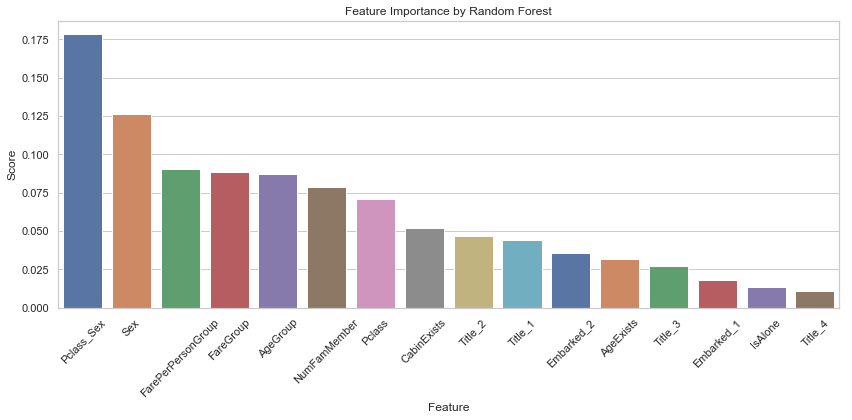

In [109]:
fiDF = pd.DataFrame({'Feature': X_train.columns, 'Score': rfClf.feature_importances_}).sort_values(by='Score', ascending=False)
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='Feature', y='Score', palette=sns.color_palette(), data=fiDF, ax=ax)
ax.set_title('Feature Importance by Random Forest')
ax.tick_params('x', labelrotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Save the random forest classifier

outPath = 'models/rf.pickle'
joblib.dump(rfClf, outPath)

## 6) Gradient Boosting

In [113]:
from sklearn.ensemble import GradientBoostingClassifier

# Instantiate Gradient Boosting classifier
gbClf = GradientBoostingClassifier()

# Cross-validation
param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5], 'n_estimators': [100, 200, 300, 400]}
cv = GridSearchCV(gbClf, param_grid=param_grid, cv=5)
cv.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [115]:
cv.best_estimator_

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.05, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
# Extract best gradient boosting estimator
gbClf = cv.best_estimator_

# Save it
outPath = 'models/gb.pickle'
joblib.dump(gbClf, outPath)

## 7) Blending

We will build an ensemble model using the blending technique. More specifically, the following steps will be conducted.

1. Split the training data into Set 1 (80%) and Set 2 (20%)
2. Train 4 types of classifiers (**logistic regression**, **K-NN**, **random forest** and **gradient boosting trees**) on Set 1.
3. After the base classifiers are trained, ask them to make prediction on Set 2 and use their predicted probabilities to train a **logistic regression** on Set 2.

### Step 1: Split the training set

In [120]:
# Split
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train, y_train, test_size=0.2, random_state=1995)

In [121]:
# Standardize the X's
scalerBlending = StandardScaler()
X_train_1_std = scalerBlending.fit_transform(X_train_1)
X_train_2_std = scalerBlending.transform(X_train_2)

### Step 2: Train base classifiers

**Logistic regression**

In [123]:
from sklearn.linear_model import LogisticRegressionCV

# Cross-validation and fit
Cs = [10**t for t in range(-3, 5)]
l1_ratios = np.array([0.0, 0.25, 0.5, 0.75, 1.0])
blendingLR = LogisticRegressionCV(Cs=Cs,
                                   penalty='elasticnet',
                                   cv=5,
                                   max_iter=1000,
                                   random_state=1995,
                                   solver='saga',
                                   l1_ratios=l1_ratios).fit(X_train_1, y_train_1)

**K-NN**

In [127]:
# Instantiate KNN classifier
blendingKNN = KNeighborsClassifier()

# Cross-validation
param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17], 'weights': ['uniform', 'distance']}
cv = GridSearchCV(knnClf, param_grid=param_grid, cv=5)
cv.fit(X_train_1_std, y_train_1)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=9, p=2,
                                            weights='distance'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17],
                         'weights': ['uniform', 'distance']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [128]:
# Extract best estimator
blendingKNN = cv.best_estimator_

**Random Forest**

In [129]:
param_grid = {'n_estimators': [25, 50, 100, 200, 400], 'max_features': ['sqrt', None]}
listOfRandomForestsBlending = []

for n in param_grid['n_estimators']:
    for m in param_grid['max_features']:
        rfClf = RandomForestClassifier(n_estimators=n, max_features=m, oob_score=True)
        rfClf.fit(X_train_1, y_train_1)
        listOfRandomForestsBlending.append(rfClf)

In [130]:
# Find the best classifier

bestScore = 0
blendingRF = None
for rf in listOfRandomForests:
    if rf.oob_score_ > bestScore:
        blendingRF = rf
        bestScore = rf.oob_score_

**Gradient Boosting Trees**

In [132]:
# Instantiate Gradient Boosting classifier
blendingGB = GradientBoostingClassifier()

# Cross-validation
param_grid = {'learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.5], 'n_estimators': [100, 200, 300, 400]}
cv = GridSearchCV(blendingGB, param_grid=param_grid, cv=5)
cv.fit(X_train_1, y_train_1)

/Users/zexi_ye/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_change=None,
                                                  presort=

In [133]:
blendingGB = cv.best_estimator_

### Step 3: Train second-level classifier

In [135]:
# Get predicted probabilities on Set 2 from base classifiers
set2Predictions = np.zeros((X_train_2.shape[0], 4))

baseClassifiers = [blendingLR, blendingKNN, blendingRF, blendingGB]
needStd = [False, True, False, False] # Since KNN takes standardized features

for i, (clf, std) in enumerate(zip(baseClassifiers, needStd)):
    if std:
        pred = clf.predict_proba(X_train_2_std)[:, 1]
    else:
        pred = clf.predict_proba(X_train_2)[:, 1]
    set2Predictions[:, i] = pred

In [137]:
# Instantiate a logistic regression

Cs = [10**t for t in range(-3, 8)]
l1_ratios = np.array([0.0, 0.25, 0.5, 0.75, 1.0])
level2Classifier = LogisticRegressionCV(Cs=Cs,
                                   penalty='elasticnet',
                                   cv=5,
                                   max_iter=1000,
                                   random_state=1995,
                                   solver='saga',
                                   l1_ratios=l1_ratios).fit(set2Predictions, y_train_2)

In [140]:
# Define a class that gives prediction based upon blending
import copy


class BlendingClassifier(object):
    
    def __init__(self, base_classifiers, level_2_classifier, need_std, scaler=None):
        self.baseClassifiers = copy.deepcopy(base_classifiers)
        self.level2Classifier = copy.deepcopy(level_2_classifier)
        self.needStd = copy.deepcopy(needStd)
        self.scaler = copy.deepcopy(scaler)
        assert len(base_classifiers) == len(need_std), 'Lengths of base_classifiers and need_std do not match'
        if scaler is None and True in needStd:
            raise Exception('Must pass in a scaler')
        
    def predict(self, X):
        basePred = self._predict(X)
        res = self.level2Classifier.predict(basePred)
        return res
    
    def predict_proba(self, X, scaler=None):
        basePred = self._predict(X)
        res = self.level2Classifier.predict_proba(basePred)
        return res        
        
    def _predict(self, X):
        basePred = np.zeros((X.shape[0], len(self.baseClassifiers)))
        for i, (clf, std) in enumerate(zip(self.baseClassifiers, self.needStd)):
            if std:
                X_std = self.scaler.transform(X)
                pred = clf.predict_proba(X_std)[:, 1]
            else:
                pred = clf.predict_proba(X)[:, 1]
            basePred[:, i] = pred
            
        return basePred

In [141]:
baseClassifiers = [blendingLR, blendingKNN, blendingRF, blendingGB]
needStd = [False, True, False, False] # Since KNN takes standardized features

blendingClf = BlendingClassifier(baseClassifiers, level2Classifier, needStd, scalerBlending)

**Save the blending model**

In [ ]:
import pickle

outPath = 'models/blending.pickle'
joblib.dump(blendingClf, outPath)

<a id=4></a>

# Validation

Having trained a wide range of classifiers above, we will evaluate our models using the validation dataset.

In [145]:
# Model names and paths
modelNames = ['Logistic Regression',
              'SVM',
              'KNN',
              'Naive Bayes',
              'Random Forest',
              'Gradient Boosting',
              'Blending']

modelPaths = ['models/lr.pickle',
              'models/svm.pickle',
              'models/knn.pickle',
              'models/nb.pickle',
              'models/rf.pickle',
              'models/gb.pickle',
              'models/blending.pkl']

## Accuracy, Precision, Recall and F-1 Score

In [146]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

acc_dict, prec_dict, recall_dict, f1_dict = {}, {}, {}, {}

for name, path in zip(modelNames, modelPaths):
    model = joblib.load(path)
    pred = model.predict(X_val)
    
    acc = accuracy_score(y_val, pred)
    prec, recall, f1, _ = precision_recall_fscore_support(y_val, pred, average='binary')
    acc_dict[name] = acc
    prec_dict[name] = prec
    recall_dict[name] = recall
    f1_dict[name] = f1

**Display the metrics in a table**

In [147]:
metricDF = pd.DataFrame([acc_dict, prec_dict, recall_dict, f1_dict]).T
metricDF.columns = ['Accuracy', 'Precision', 'Recall', 'F1Score']
metricDF

,Accuracy,Precision,Recall,F1Score
Logistic Regression,0.855556,0.920000,0.676471,0.779661
SVM,0.855556,0.888889,0.705882,0.786885
KNN,0.866667,0.843750,0.794118,0.818182
Naive Bayes,0.733333,0.625000,0.735294,0.675676
Random Forest,0.822222,0.764706,0.764706,0.764706
Gradient Boosting,0.855556,0.888889,0.705882,0.786885
Blending,0.833333,0.771429,0.794118,0.782609


## ROC Curve

In [148]:
from sklearn.metrics import roc_curve, auc

In [149]:
# Get false positive rate, true positive rate and auc 

fpr_dict = {}
tpr_dict = {}
auc_dict = {}

for name, path in zip(modelNames, modelPaths):
    model = joblib.load(path)
    predProba = model.predict_proba(X_val)[:, 1]
    fpr, tpr, _ = roc_curve(y_val, predProba)
    area = auc(fpr, tpr)
    fpr_dict[name] = fpr
    tpr_dict[name] = tpr
    auc_dict[name] = area
    

In [150]:
# Order the results in descending order
nameInOrder = pd.Series(auc_dict).sort_values(ascending=False).index.tolist()

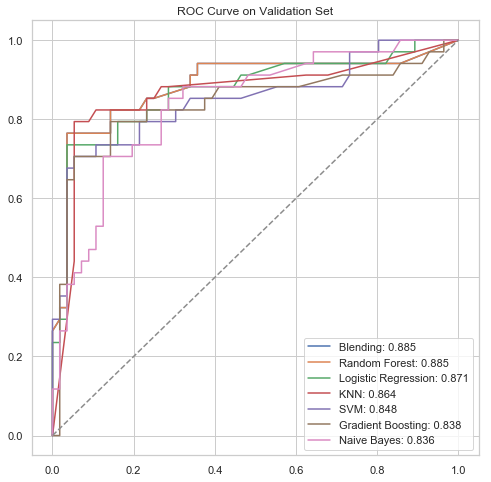

In [151]:
fig, ax = plt.subplots(figsize=(8, 8))

for name in nameInOrder:
    ax.plot(fpr_dict[name], tpr_dict[name], label=f'{name}: {auc_dict[name]:0.3f}')

ax.plot((0, 1), (0, 1), '--')
ax.legend()
ax.set_title('ROC Curve on Validation Set')
plt.show()

<a id=5></a>

# Predictions on Test Set

## Preprocess the test data

In [7]:
# Load data
testData = pd.read_csv('data/test.csv')

In [8]:
testData.isnull().any()

PassengerId    False
Pclass         False
Name           False
Sex            False
Age             True
SibSp          False
Parch          False
Ticket         False
Fare            True
Cabin           True
Embarked       False
dtype: bool

In [10]:
# Fill the NA's

# We will fill NA's in Fare using median
testData = testData.fillna({'Fare': testData.Fare.median()})

# Add engineered features to testData
testDataAugmented = augmentDataFrame(testData, titleCorrectionDict, titleToNum, ageRange, fareRange, farePerPersonRange)

# Define encodeCols
encodeCols = ['Embarked', 'Title']
# Drop extraneous columns and perform one-hot encoding
keepColsTest = ['Pclass',
            'Sex',
            'Embarked',
            'NumFamMember',
            'IsAlone',
            'Title',
            'AgeExists',
            'AgeGroup',
            'CabinExists',
            'Pclass_Sex',
            'FareGroup',
            'FarePerPersonGroup']
X_test = cleanAndOneHotEncoding(testDataAugmented, keepColsTest, encodeCols)

## Apply models on preprocessed test data

In this section, we will generate predictions on the test set using all of our trained classifiers.

### 1. Logistic regression

In [168]:
# Load model
modelPath = 'models/lr.pickle'
clfLR = joblib.load(modelPath)

# Predict
testPredLR = clfLR.predict(X_test)

### 2. SVM

In [16]:
# Load model
modelPath = 'models/svm.pickle'
clfSVM = joblib.load(modelPath)

# Predict
testPredSVM = clfSVM.predict(X_test)

### 3. K-NN

In [171]:
# Load model
modelPath = 'models/knn.pickle'
clfKNN = joblib.load(modelPath)

# Predict
testPredKNN = clfKNN.predict(X_test)

### 4. Naive Bayes

In [19]:
# Load model
modelPath = 'models/nb.pickle'
clfNB = joblib.load(modelPath)

# Predict
testPredNB = clfNB.predict(X_test)

### 5. Random forest

In [175]:
# Load model
modelPath = 'models/rf.pickle'
clfRF = joblib.load(modelPath)

# Predict
testPredRF = clfRF.predict(X_test)

### 6. Gradient boosting

In [13]:
# Load model
modelPath = 'models/gb.pickle'
clfGB = joblib.load(modelPath)

# Predict
testPredGB = clfGB.predict(X_test)

### 7. Blending

In [176]:
# Load model
modelPath = 'models/blending.pickle'
clfBlending = joblib.load(modelPath)

# Predict
testPredBlending = clfBlending.predict(X_test)

In [178]:
pd.DataFrame({'LR': testPredLR, 'KNN': testPredKNN, 'RF': testPredRF, 'Blending': testPredBlending})

,LR,KNN,RF,Blending
0,0,0,0,0
1,0,0,0,0
2,0,0,0,1
3,0,0,0,0
4,1,1,1,1
...,...,...,...,...
413,0,0,0,0
414,1,1,1,1
415,0,0,0,0
416,0,0,0,0


### Reformat and save predictions

Convert the predictions into desired form and save, respectively.

In [179]:
preds = [testPredLR, testPredSVM, testPredKNN, testPredNB, testPredRF, testPredGB, testPredBlending]
suffices = ['lr', 'svm', 'knn', 'nb', 'rf', 'gb', 'blending']

for pred, suffix in zip(preds, suffices):
    # Create a dataframe
    testOutput = pd.DataFrame({'PassengerId': testData.PassengerId, 'Survived': pred})

    # Save
    testOutput.to_csv('output/submission_{}.csv'.format(suffix), index=False)